In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
import tqdm
import matplotlib.gridspec as gridspec
import graphviz

from dask import delayed
from joblib import parallel_backend
from dask.distributed import Client, progress
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
#from yellowbrick.model_selection import FeatureImportances
from imblearn.under_sampling import NearMiss

#from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [4]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K'])
Z, Zs = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

train_df = Zs_train.copy()
train_df['$$$'] = ys_train

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)
Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

In [11]:
nm = NearMiss(version=1)

with parallel_backend('threading', n_jobs=-1):
#     Z_train_resampled, q_train_resampled = nm.fit_resample(Z_train[:1000], q_train[:1000])
    Z_train_resampled, q_train_resampled = nm.fit_resample(Z_train, q_train)


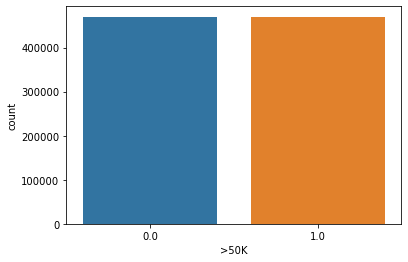

In [12]:
sns.countplot(q_train_resampled['>50K'])

### Random Forest Classifier

In [14]:
min_samples_split = [2,4,6,10,20]

for splits in min_samples_split:
    rf = RandomForestClassifier(min_samples_split=splits)
    rf.fit(Zs_train, ys_train)
    print('----------------------------------')
    print(f"Min samples split = {splits}")
    print(f'r2 train= {rf.score(Zs_train, ys_train)}')
    print(f'r2 test= {rf.score(Zs_test, ys_test)}')
    print('----------------------------------')
    rf.fit(Zs_train_scaled, ys_train)
    print('----------------------------------')
    print(f"Min samples split = {splits}")
    print(f'r2 train scaled= {rf.score(Zs_train_scaled, ys_train)}')
    print(f'r2 test= {rf.score(Zs_test, ys_test)}')
    print('----------------------------------')

<ipython-input-14-353889209e79>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train, ys_train)


----------------------------------
Min samples split = 2
r2 train= 0.994625
r2 test= 0.8092
----------------------------------


<ipython-input-14-353889209e79>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 2
r2 train scaled= 0.994625
r2 test= 0.3278
----------------------------------


<ipython-input-14-353889209e79>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train, ys_train)


----------------------------------
Min samples split = 4
r2 train= 0.9777
r2 test= 0.8151
----------------------------------


<ipython-input-14-353889209e79>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 4
r2 train scaled= 0.97775
r2 test= 0.488
----------------------------------


<ipython-input-14-353889209e79>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train, ys_train)


----------------------------------
Min samples split = 6
r2 train= 0.9541
r2 test= 0.8191
----------------------------------


<ipython-input-14-353889209e79>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 6
r2 train scaled= 0.954225
r2 test= 0.486
----------------------------------


<ipython-input-14-353889209e79>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train, ys_train)


----------------------------------
Min samples split = 10
r2 train= 0.923725
r2 test= 0.8193
----------------------------------


<ipython-input-14-353889209e79>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 10
r2 train scaled= 0.9235
r2 test= 0.4862
----------------------------------


<ipython-input-14-353889209e79>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train, ys_train)


----------------------------------
Min samples split = 20
r2 train= 0.886175
r2 test= 0.8216
----------------------------------


<ipython-input-14-353889209e79>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 20
r2 train scaled= 0.8866
r2 test= 0.3324
----------------------------------


### Random Forest w/Resampled Data

In [15]:
min_samples_split = [2,4,6,10,20]

for splits in min_samples_split:
    rf = RandomForestClassifier(min_samples_split=splits)
    rf.fit(Z_train_resampled, q_train_resampled)
    print('----------------------------------')
    print(f"Min samples split = {splits}")
    print(f'r2 train= {rf.score(Z_train_resampled, q_train_resampled)}')
    print(f'r2 test= {rf.score(Z_test, y_test)}')
    print('----------------------------------')
    rf.fit(Zs_train_scaled, ys_train)
    print('----------------------------------')
    print(f"Min samples split = {splits}")
    print(f'r2 train scaled= {rf.score(Zs_train_scaled, ys_train)}')
    print(f'r2 test= {rf.score(Zs_test, ys_test)}')
    print('----------------------------------')

<ipython-input-15-a436b139bec8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Z_train_resampled, q_train_resampled)


----------------------------------
Min samples split = 2
r2 train= 0.9622435585132297
r2 test= 0.6562576925391259
----------------------------------


<ipython-input-15-a436b139bec8>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 2
r2 train scaled= 0.994675
r2 test= 0.3616
----------------------------------


<ipython-input-15-a436b139bec8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Z_train_resampled, q_train_resampled)


----------------------------------
Min samples split = 4
r2 train= 0.9446216165041624
r2 test= 0.6570864354209631
----------------------------------


<ipython-input-15-a436b139bec8>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 4
r2 train scaled= 0.977675
r2 test= 0.3272
----------------------------------


<ipython-input-15-a436b139bec8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Z_train_resampled, q_train_resampled)


----------------------------------
Min samples split = 6
r2 train= 0.9246849729490532
r2 test= 0.6581394585546505
----------------------------------


<ipython-input-15-a436b139bec8>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 6
r2 train scaled= 0.95435
r2 test= 0.3289
----------------------------------


<ipython-input-15-a436b139bec8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Z_train_resampled, q_train_resampled)


----------------------------------
Min samples split = 10
r2 train= 0.9004614510710813
r2 test= 0.6613641709562544
----------------------------------


<ipython-input-15-a436b139bec8>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 10
r2 train scaled= 0.92395
r2 test= 0.3596
----------------------------------


<ipython-input-15-a436b139bec8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Z_train_resampled, q_train_resampled)


----------------------------------
Min samples split = 20
r2 train= 0.8732573254559728
r2 test= 0.6662791906218033
----------------------------------


<ipython-input-15-a436b139bec8>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train_scaled, ys_train)


----------------------------------
Min samples split = 20
r2 train scaled= 0.886325
r2 test= 0.3556
----------------------------------


In [37]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K'])
Z, Zs = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

Z_train, Z_val, q_train, q_val = train_test_split(Z_train, q_train, test_size=0.25, random_state=2)
Zs_train, Zs_val, qs_train, qs_val = train_test_split(Zs_train, qs_train, test_size=0.25, random_state=2)

train_df = Zs_train.copy()
train_df['$$$'] = ys_train

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)
Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [39]:
len(Xs_test)

10000

In [54]:
import xgboost as xgb
import time



for n in range(1, 17):
    gbm = xgb.XGBClassifier( 
                            n_estimators=30000,
                            max_depth=4,
                            objective='binary:logistic', #new objective
                            learning_rate=.05, 
                            subsample=.8,
                            min_child_weight=3,
                            colsample_bytree=.8,
                            nthread=n
                           )

    eval_set=[(Zs_train, qs_train),(Zs_val, qs_val)]
    start = time.time()
    fit_model = gbm.fit( 
                        Zs_train, qs_train, 
                        eval_set=eval_set,
                        eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                        early_stopping_rounds=50,
                        verbose=False
                       )

    print(accuracy_score(qs_test, gbm.predict(Zs_test, ntree_limit=gbm.best_ntree_limit)))
    
    elapsed = time.time() - start
    print(n, elapsed)

0.8217
1 4.076961278915405
0.8217
2 2.216935157775879
0.8217
3 1.5573580265045166
0.8217
4 1.3545753955841064
0.8217
5 1.1674840450286865
0.8217
6 1.0030782222747803
0.8217
7 0.9129178524017334
0.8217
8 1.0880420207977295
0.8217
9 1.1314473152160645
0.8217
10 1.1340904235839844
0.8217
11 1.1690552234649658
0.8217
12 1.2589097023010254
0.8217
13 1.2974598407745361
0.8217
14 1.3120152950286865
0.8217
15 1.4089183807373047
0.8217
16 1.7923393249511719


AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

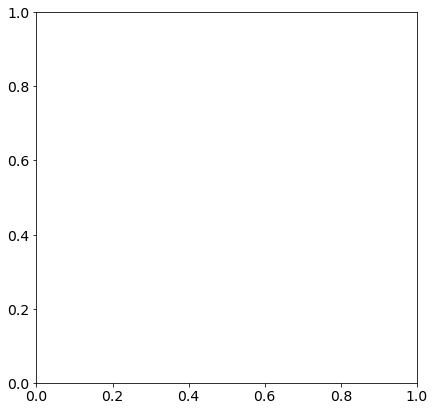

In [60]:
fig = plt.figure(figsize = (15,15))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
plt.rcParams.update({'font.size': 14})
plt.rc('axes', titlesize = 14, labelsize = 14)

ax2 = fig.add_subplot(spec[0,1])
fpr, tpr, threshold_curve = roc_curve(y_test, lr.predict_proba(Xs_test)[:,1] )
plt.plot(fpr, tpr,lw=2, color = 'navy')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve for Logistic Regression');

In [61]:
Xs_test[:, 1]

TypeError: '(slice(None, None, None), 1)' is an invalid key